# Laplace Approximation  + Logistic Regression

This notebook includes:

- What the **Hessian** means (curvature in 1D and many dimensions)
- What the **Laplace approximation** does (approximate a posterior by a Gaussian)
- When Laplace works well vs. poorly
- Simple examples + a practical **Bayesian logistic regression** example
- Engineering Example: Component Failure Prediction using MCMC



---


In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
plt.rcParams.update({
    'figure.figsize': (8, 4.8),
    'axes.grid': True,
    'font.size': 11,
})

def sigmoid(z):
    return 1/(1+np.exp(-z))

print('Ready.')


Ready.


## 1) What is the Hessian?

### 1.1 1D: second derivative = curvature
For a 1D function \(f(x)\):

- \(f'(x)\) tells you the **slope**.
- \(f''(x)\) tells you how the slope changes — the **curvature**.

If we look at a **peak** of a log-density, strong curvature means the peak is sharp → **small uncertainty**.

### 1.2 Multi-D: Hessian matrix = curvature in all directions
For \(f(\theta)\) with \(\theta \in \mathbb{R}^d\), the Hessian is a matrix:

$
H_{ij}(\theta) = \frac{\partial^2 f}{\partial \theta_i\partial \theta_j}.
$

- Diagonal terms: curvature along each coordinate.
- Off-diagonal terms: how directions interact → **correlation/tilt** in uncertainty ellipses.

We’ll visualize this next.


Approx f"(0) wide : -0.39062499999999994
Approx f"(0) sharp: -2.777777777777778
More negative curvature at the top => narrower distribution.


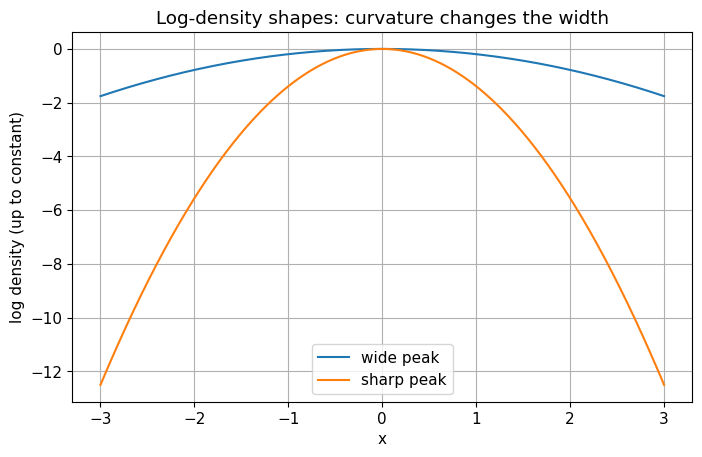

In [15]:
# 1D curvature demo
x = np.linspace(-3, 3, 600)

# Two functions: one wide, one sharp
f_wide = -0.5*(x/1.6)**2
f_sharp = -0.5*(x/0.6)**2

plt.plot(x, f_wide, label='wide peak')
plt.plot(x, f_sharp, label='sharp peak')
plt.title('Log-density shapes: curvature changes the width')
plt.xlabel('x')
plt.ylabel('log density (up to constant)')
plt.legend();

# approximate second derivative at 0 using finite differences
h = x[1]-x[0]
idx0 = np.argmin(np.abs(x))

def second_derivative(y, i, h):
    return (y[i+1] - 2*y[i] + y[i-1])/(h**2)

print('Approx f"(0) wide :', second_derivative(f_wide, idx0, h))
print('Approx f"(0) sharp:', second_derivative(f_sharp, idx0, h))
print('More negative curvature at the top => narrower distribution.')


### 1.3 2D Hessian → uncertainty ellipse
If the negative log posterior near the MAP looks like

$
U(\theta) \approx U(\hat\theta) + \tfrac12 (\theta-\hat\theta)^\top H (\theta-\hat\theta),
$

then the Laplace approximation gives

$
\theta \sim \mathcal{N}(\hat\theta,\ H^{-1}).
$

So:
- **Hessian** \(H\) describes curvature.
- **Covariance** is $(H^{-1})$.

We’ll draw ellipses to show how off-diagonal terms produce tilt/correlation.


H2 =
 [[4. 3.]
 [3. 4.]]
Covariance = inv(H2) =
 [[ 0.57142857 -0.42857143]
 [-0.42857143  0.57142857]]
Off-diagonal covariance indicates correlation/tilt.


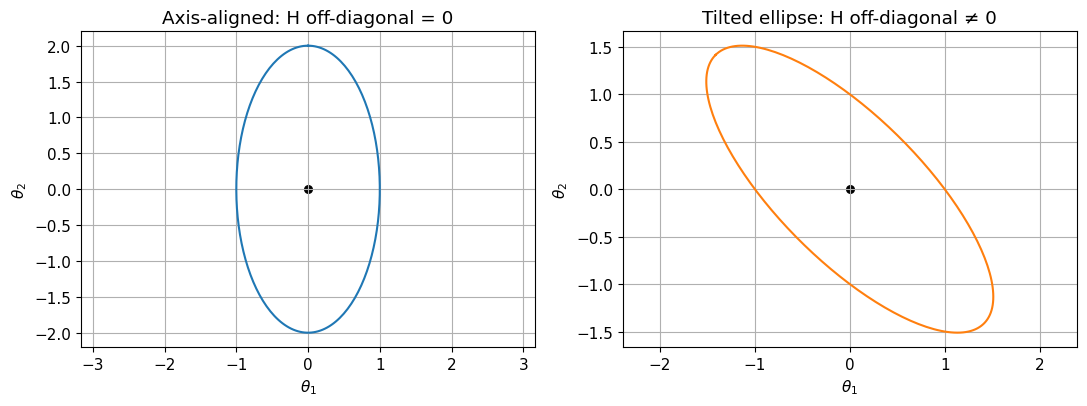

In [16]:
def plot_cov_ellipse(ax, mu, Sigma, n_std=2.0, **kwargs):
    # Ellipse for a 2D covariance
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

    # width/height = 2 * n_std * sqrt(eigenvalues)
    width, height = 2*n_std*np.sqrt(vals)

    t = np.linspace(0, 2*np.pi, 200)
    circle = np.vstack([np.cos(t), np.sin(t)])
    ellipse = (vecs @ (np.diag(np.sqrt(vals)) @ circle))
    ellipse = mu[:,None] + n_std*ellipse
    ax.plot(ellipse[0], ellipse[1], **kwargs)

mu = np.array([0.0, 0.0])
H1 = np.array([[4.0, 0.0],[0.0, 1.0]])          # axis-aligned curvature
H2 = np.array([[4.0, 3.0],[3.0, 4.0]])          # correlated curvature

Sigma1 = np.linalg.inv(H1)
Sigma2 = np.linalg.inv(H2)

fig, ax = plt.subplots(1,2, figsize=(11,4.2))
ax[0].set_title('Axis-aligned: H off-diagonal = 0')
plot_cov_ellipse(ax[0], mu, Sigma1, n_std=2, color='C0')
ax[0].scatter([0],[0], c='k', s=30)
ax[0].set_xlabel(r'$\theta_1$'); ax[0].set_ylabel(r'$\theta_2$')
ax[0].axis('equal')

ax[1].set_title('Tilted ellipse: H off-diagonal ≠ 0')
plot_cov_ellipse(ax[1], mu, Sigma2, n_std=2, color='C1')
ax[1].scatter([0],[0], c='k', s=30)
ax[1].set_xlabel(r'$\theta_1$'); ax[1].set_ylabel(r'$\theta_2$')
ax[1].axis('equal')

plt.tight_layout();

print('H2 =\n', H2)
print('Covariance = inv(H2) =\n', Sigma2)
print('Off-diagonal covariance indicates correlation/tilt.')


## 2) Laplace Approximation

### 2.1 The core idea
Given a target density (often a posterior) \(p(\theta\mid y)\), define

$
U(\theta) = -\log p(\theta\mid y) \quad \text{(negative log posterior)}.
$

Find the MAP:
$
\hat\theta = \arg\min U(\theta).
$

Then approximate \(U\) near \(\hat\theta\) by a quadratic (2nd-order Taylor expansion):

$
U(\theta) \approx U(\hat\theta) + \tfrac12 (\theta-\hat\theta)^\top H (\theta-\hat\theta),
$
where $(H = \nabla^2 U(\hat\theta))$ is the Hessian at the MAP.

Exponentiating gives a Gaussian:

$
p(\theta\mid y) \approx \mathcal{N}(\hat\theta,\ H^{-1}).
$

**Translation:** mode becomes the mean; curvature becomes the variance.

---


## 3) Simple 1D Example: exact vs Laplace

We build a slightly non-Gaussian density:

$
p(x) \propto \exp(-x^2 - 0.1x^4).
$

Near $x=0$ it looks Gaussian, but tails differ. We will:

1. Compute the exact normalized density numerically.
2. Compute Laplace approximation at the mode.
3. Compare the curves.


/tmp/ipython-input-1757634308.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(unnorm, xs)


Laplace variance sigma^2 = 0.5
Interpretation: bigger curvature H => smaller sigma^2.


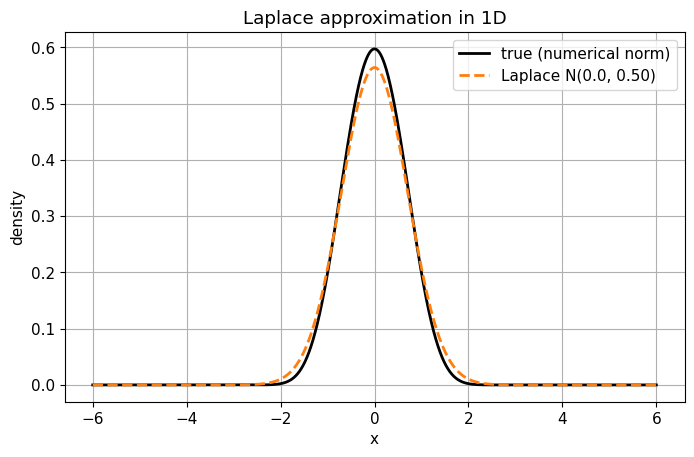

In [17]:
# Define unnormalized log density

def logp(x):
    return -(x**2 + 0.1*x**4)

def U(x):
    return -logp(x)

# Mode is at x_hat = 0 by symmetry
x_hat = 0.0

# Hessian in 1D is just U''(x_hat)
# U(x) = x^2 + 0.1 x^4 => U''(x) = 2 + 1.2 x^2 => U''(0)=2
H = 2.0
sigma2 = 1/H

# Numerical normalization for the "true" density
xs = np.linspace(-6, 6, 2000)
unnorm = np.exp(logp(xs))
Z = np.trapz(unnorm, xs)
true_pdf = unnorm / Z

# Laplace Gaussian pdf
lap_pdf = (1/np.sqrt(2*np.pi*sigma2))*np.exp(-(xs-x_hat)**2/(2*sigma2))

plt.plot(xs, true_pdf, 'k-', lw=2, label='true (numerical norm)')
plt.plot(xs, lap_pdf, 'C1--', lw=2, label=f'Laplace N({x_hat:.1f}, {sigma2:.2f})')
plt.title('Laplace approximation in 1D')
plt.xlabel('x')
plt.ylabel('density')
plt.legend();

print('Laplace variance sigma^2 =', sigma2)
print('Interpretation: bigger curvature H => smaller sigma^2.')


### 3.1 Quadratic (parabola) view: why it becomes Gaussian
Laplace is just a quadratic approximation to \(\log p(x)\) around the peak.
We compare:

- $\log p(x)$
- the quadratic approximation $\log p(\hat x) - \tfrac12 H (x-\hat x)^2$


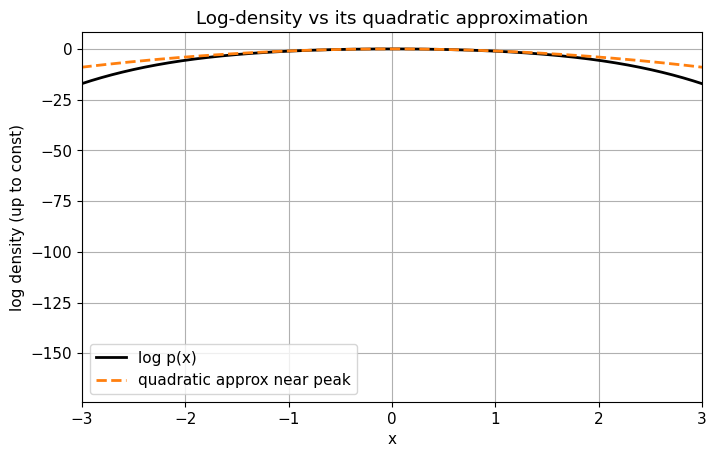

In [18]:
log_true = logp(xs)
log_quad = logp(x_hat) - 0.5*H*(xs-x_hat)**2

plt.plot(xs, log_true, 'k-', lw=2, label='log p(x)')
plt.plot(xs, log_quad, 'C1--', lw=2, label='quadratic approx near peak')
plt.xlim(-3,3)
plt.title('Log-density vs its quadratic approximation')
plt.xlabel('x')
plt.ylabel('log density (up to const)')
plt.legend();


## 4) When Laplace can fail: a bimodal target

If the true density has **two peaks**, a single Gaussian around one peak cannot capture both.

Example:
$
p(x)=0.5\,\mathcal{N}(-3,1)+0.5\,\mathcal{N}(+3,1).
$
Laplace around one mode will miss the other.


/tmp/ipython-input-14251450.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z = np.trapz(unn, xs)


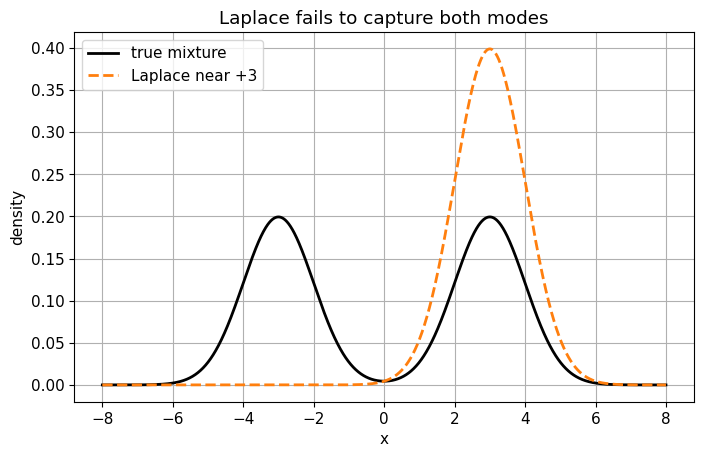

In [19]:
from math import log

def logsumexp(a, b):
    m = max(a, b)
    return m + np.log(np.exp(a-m) + np.exp(b-m))

def log_mix(x):
    # mixture of N(-3,1) and N(3,1), ignoring normalizing constants
    a = -0.5*(x+3)**2
    b = -0.5*(x-3)**2
    return logsumexp(a, b)

xs = np.linspace(-8, 8, 2000)
unn = np.exp([log_mix(x) for x in xs])
Z = np.trapz(unn, xs)
true_pdf = unn/Z

# Choose Laplace around the right mode near +3
x_hat = 3.0
# For a standard normal component, local curvature ~ 1 at the mode.
H = 1.0
sigma2 = 1/H
lap_pdf = (1/np.sqrt(2*np.pi*sigma2))*np.exp(-(xs-x_hat)**2/(2*sigma2))

plt.plot(xs, true_pdf, 'k-', lw=2, label='true mixture')
plt.plot(xs, lap_pdf, 'C1--', lw=2, label='Laplace near +3')
plt.title('Laplace fails to capture both modes')
plt.xlabel('x'); plt.ylabel('density'); plt.legend();


## 5) Practical Example: Bayesian Logistic Regression via Laplace

### Goal
Compute **credible intervals** for logistic regression coefficients.

Model:
$
\Pr(y_i=1\mid x_i,\beta)=\sigma(\alpha + x_i^\top\beta).
$
Prior (simple, after standardizing features):
$
\alpha\sim\mathcal{N}(0,5^2),\quad \beta_j\sim\mathcal{N}(0,2^2).
$

### Laplace steps
1. Find MAP by minimizing negative log posterior $(U(\theta))$.
2. Compute Hessian $(H=\nabla^2 U(\hat\theta))$.
3. Approximate posterior as $(\mathcal{N}(\hat\theta, H^{-1}))$.
4. Sample from that Gaussian to get credible intervals and predictive uncertainty.

> This gives **fast approximate uncertainty**. For more accurate posteriors, use NUTS/HMC.


In [20]:
# Generate synthetic logistic regression data (2 features)
N = 400
X = np.random.normal(size=(N, 2))
# Standardize features (important for sensible priors)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

beta_true = np.array([1.3, -0.9])
alpha_true = -0.2
logits = alpha_true + X @ beta_true
p = sigmoid(logits)
y = (np.random.rand(N) < p).astype(int)

print('y mean (class balance):', y.mean())


y mean (class balance): 0.4625


In [21]:
# Negative log posterior for theta = [alpha, beta1, beta2]

s_alpha = 5.0  # prior std for intercept
s_beta = 2.0   # prior std for coefficients

X_design = np.column_stack([np.ones(N), X])  # add intercept column

def U_theta(theta):
    # theta: (3,)
    z = X_design @ theta
    p = sigmoid(z)
    # negative log likelihood
    eps = 1e-12
    nll = -np.sum(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
    # negative log prior (Gaussian)
    prior = 0.5*(theta[0]/s_alpha)**2 + 0.5*np.sum((theta[1:]/s_beta)**2)
    return nll + prior

def grad_U(theta):
    z = X_design @ theta
    p = sigmoid(z)
    # gradient of nll: X^T (p - y)
    g = X_design.T @ (p - y)
    # prior gradient
    g[0] += theta[0]/(s_alpha**2)
    g[1:] += theta[1:]/(s_beta**2)
    return g

def hess_U(theta):
    z = X_design @ theta
    p = sigmoid(z)
    w = p*(1-p)  # (N,)
    # Hessian of nll: X^T W X
    H = X_design.T @ (X_design * w[:,None])
    # prior Hessian
    H[0,0] += 1/(s_alpha**2)
    H[1,1] += 1/(s_beta**2)
    H[2,2] += 1/(s_beta**2)
    return H

# Newton's method for MAP (convex objective -> usually stable)
theta = np.zeros(3)
for it in range(20):
    g = grad_U(theta)
    H = hess_U(theta)
    step = np.linalg.solve(H, g)
    theta_new = theta - step
    if np.linalg.norm(theta_new-theta) < 1e-8:
        theta = theta_new
        break
    theta = theta_new

theta_hat = theta
H_hat = hess_U(theta_hat)
Sigma_hat = np.linalg.inv(H_hat)

print('MAP theta_hat = [alpha, beta1, beta2]:', theta_hat)
print('Posterior (Laplace) std dev:', np.sqrt(np.diag(Sigma_hat)))


MAP theta_hat = [alpha, beta1, beta2]: [-0.21559822  1.40695177 -0.94262586]
Posterior (Laplace) std dev: [0.12274584 0.16309123 0.14515683]


### 5.1 Credible intervals from Laplace
For a Gaussian approximation, 95% credible intervals are approximately
$(\hat\theta \pm 1.96\,\text{sd})$.

We also sample from $(\mathcal{N}(\hat\theta,\Sigma))$ to show Monte Carlo intervals and to compute predictive uncertainty.


In [22]:
sd = np.sqrt(np.diag(Sigma_hat))
ci_approx = np.column_stack([theta_hat - 1.96*sd, theta_hat + 1.96*sd])

names = ['alpha','beta1','beta2']
for i,nm in enumerate(names):
    print(f"{nm}: MAP={theta_hat[i]: .3f}   approx 95% CI=({ci_approx[i,0]: .3f}, {ci_approx[i,1]: .3f})")

# Monte Carlo from Laplace posterior
S = 50_000
samples = np.random.multivariate_normal(theta_hat, Sigma_hat, size=S)
ci_mc = np.quantile(samples, [0.025,0.5,0.975], axis=0)
print('\nMonte Carlo quantiles (2.5%, 50%, 97.5%):')
for i,nm in enumerate(names):
    print(f"{nm}: {ci_mc[:,i]}")


alpha: MAP=-0.216   approx 95% CI=(-0.456,  0.025)
beta1: MAP= 1.407   approx 95% CI=( 1.087,  1.727)
beta2: MAP=-0.943   approx 95% CI=(-1.227, -0.658)

Monte Carlo quantiles (2.5%, 50%, 97.5%):
alpha: [-0.45575708 -0.21642922  0.02338005]
beta1: [1.08768973 1.40789111 1.72818738]
beta2: [-1.22638698 -0.94525876 -0.65929028]


### 5.2 Predictive uncertainty: probability bands
For a new input $(x_*)$, the predicted probability is
$(\sigma(\alpha + x_*^\top\beta))$.

Under the Laplace posterior, this becomes a **distribution of probabilities**.
We’ll plot the median and 95% band of predicted probabilities along a 1D slice.


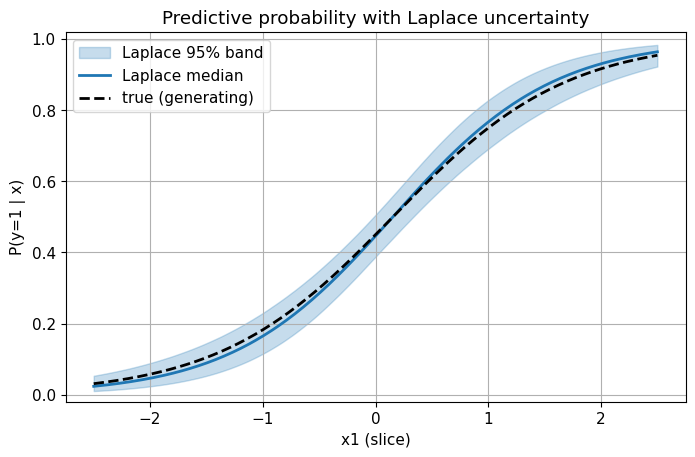

In [23]:
# Create a 1D slice through feature space: vary x1, keep x2=0
x1_grid = np.linspace(-2.5, 2.5, 200)
X_star = np.column_stack([x1_grid, np.zeros_like(x1_grid)])
X_star = (X_star - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)  # same standardization style
X_star_design = np.column_stack([np.ones(len(x1_grid)), X_star])

# Compute predictive probabilities for each posterior draw (vectorized)
# logits: (S, n_grid)
logits_s = samples @ X_star_design.T
p_s = 1/(1+np.exp(-logits_s))

p_med = np.quantile(p_s, 0.5, axis=0)
p_lo  = np.quantile(p_s, 0.025, axis=0)
p_hi  = np.quantile(p_s, 0.975, axis=0)

# true model curve (for reference)
logits_true = alpha_true + ( (np.column_stack([x1_grid, np.zeros_like(x1_grid)]) ) @ beta_true )
p_true = sigmoid(logits_true)

plt.fill_between(x1_grid, p_lo, p_hi, color='C0', alpha=0.25, label='Laplace 95% band')
plt.plot(x1_grid, p_med, 'C0', lw=2, label='Laplace median')
plt.plot(x1_grid, p_true, 'k--', lw=2, label='true (generating)')
plt.title('Predictive probability with Laplace uncertainty')
plt.xlabel('x1 (slice)')
plt.ylabel('P(y=1 | x)')
plt.ylim(-0.02, 1.02)
plt.legend();


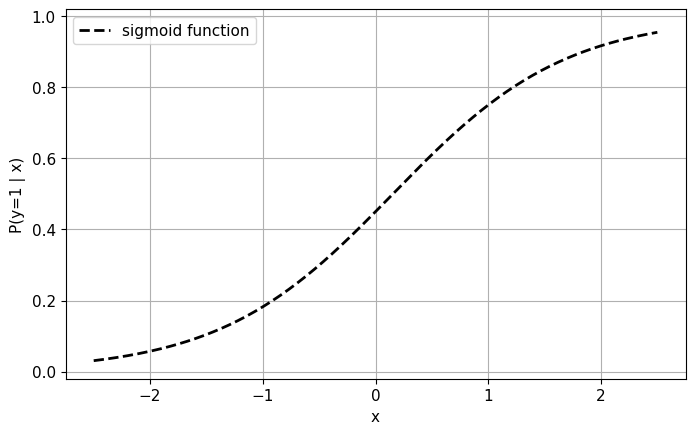

In [24]:
plt.plot(x1_grid, p_true, 'k--', lw=2, label='sigmoid function')
plt.xlabel('x')
plt.ylabel('P(y=1 | x)')
plt.ylim(-0.02, 1.02)
plt.legend();

## 6) Optional: Compare Laplace vs NUTS (NumPyro)

If **NumPyro + JAX** are installed, this cell runs NUTS for the same logistic model and compares posterior means/intervals.

- If not installed, it prints a friendly message.
- This is optional; Laplace alone requires only NumPy.


In [25]:
try:
    !pip install numpyro
    import jax
    import jax.numpy as jnp
    from jax import random

    import numpyro
    import numpyro.distributions as dist
    from numpyro.infer import NUTS, MCMC

    numpyro.set_host_device_count(2)

    Xj = jnp.array(X)
    yj = jnp.array(y)

    def model(X, y=None):
        alpha = numpyro.sample('alpha', dist.Normal(0, s_alpha))
        beta  = numpyro.sample('beta',  dist.Normal(0, s_beta).expand([2]))
        with numpyro.plate('data', X.shape[0]):
            logits = alpha + jnp.dot(X, beta)
            numpyro.sample('y', dist.Bernoulli(logits=logits), obs=y)

    rng = random.PRNGKey(1)
    kernel = NUTS(model, target_accept_prob=0.9)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2, progress_bar=False)
    mcmc.run(rng, X=Xj, y=yj)
    s = mcmc.get_samples(group_by_chain=False)

    alpha_n = np.array(s['alpha'])
    beta_n  = np.array(s['beta'])

    print('--- NUTS posterior summary (median and 95% CI) ---')
    def q(x):
        return np.quantile(x, [0.025,0.5,0.975])

    print('alpha:', q(alpha_n))
    print('beta1:', q(beta_n[:,0]))
    print('beta2:', q(beta_n[:,1]))

    print('\n--- Laplace summary ---')
    print('alpha:', np.quantile(samples[:,0], [0.025,0.5,0.975]))
    print('beta1:', np.quantile(samples[:,1], [0.025,0.5,0.975]))
    print('beta2:', np.quantile(samples[:,2], [0.025,0.5,0.975]))

except Exception as e:
    print('NumPyro/JAX not available in this environment (optional section).')
    print('Error:', repr(e))


--- NUTS posterior summary (median and 95% CI) ---
alpha: [-0.46606978 -0.21995109  0.02471425]
beta1: [1.11510328 1.42259979 1.75640894]
beta2: [-1.22967408 -0.94952363 -0.6873335 ]

--- Laplace summary ---
alpha: [-0.45575708 -0.21642922  0.02338005]
beta1: [1.08768973 1.40789111 1.72818738]
beta2: [-1.22638698 -0.94525876 -0.65929028]



## Engineering Example: Component Failure Prediction

### Scenario
We want to predict mechanical component failure based on sensor data.

- **x₁**: Operating Temperature (Normalized)  
- **x₂**: Vibration Frequency (Normalized)  
- **y ∈ {0, 1}**: Functional vs. Failed  

### Why Bayesian?
- We have limited failure data (**rare events**).
- We need to know **when** the model is uncertain to trigger manual inspection.



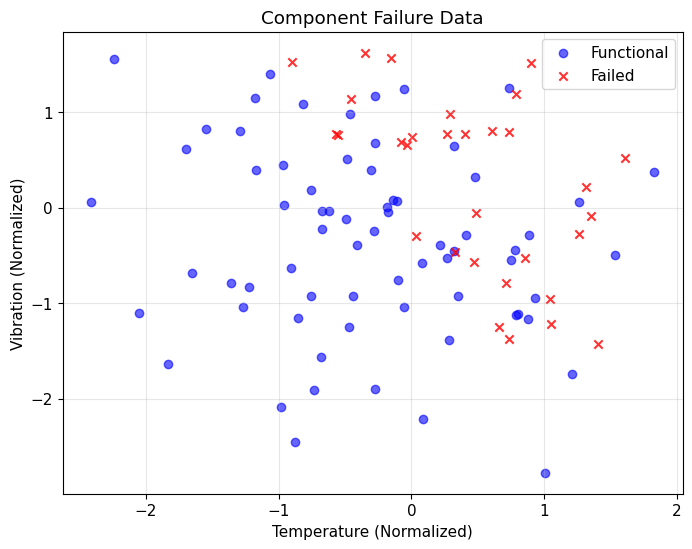

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b     -0.96      0.27     -0.96     -1.38     -0.48   2655.78      1.00
      w[0]      1.71      0.40      1.69      1.03      2.36   2296.08      1.00
      w[1]      1.20      0.33      1.19      0.68      1.76   2206.01      1.00

Number of divergences: 0


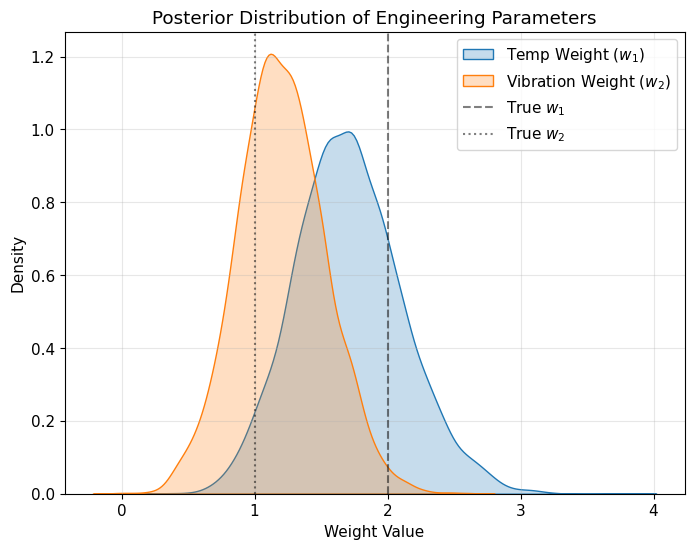

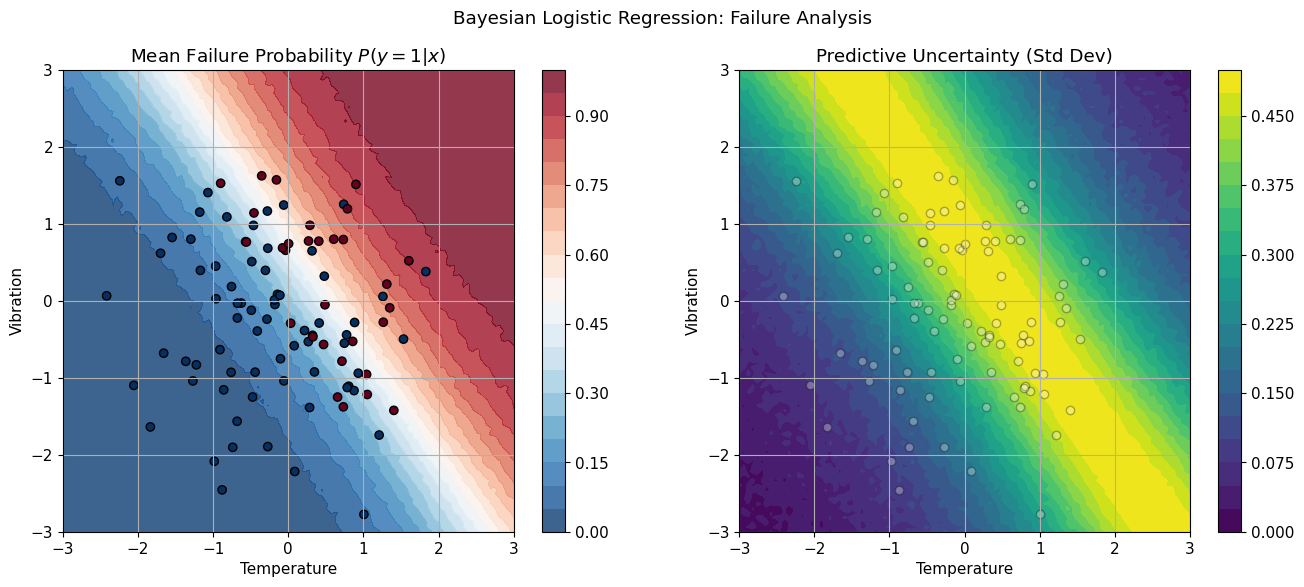

In [26]:
# %%
#!pip install numpyro
import jax
import jax.random as random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seed for reproducibility
rng_key = random.PRNGKey(42)

# %% [markdown]
# ## 1. Generate Synthetic Engineering Data
# We simulate 100 components. Failure occurs more often at high temp and high vibration.

# %%
def generate_data(N=100, key=rng_key):
    key, subkey = random.split(key)

    # Features: Temperature (x1) and Vibration (x2)
    # Centered at 0 for numerical stability
    X = random.normal(subkey, (N, 2))

    # True weights (Ground Truth)
    # Bias = -1 (baseline healthy), w1 = 2.0 (Temp sensitivity), w2 = 1.0 (Vibration sensitivity)
    true_w = jnp.array([2.0, 1.0])
    true_b = -1.0

    # True Logits and Probabilities
    logits = jnp.dot(X, true_w) + true_b
    probs = jax.nn.sigmoid(logits)

    # Generate binary observations (0 = Functional, 1 = Failed)
    key, subkey = random.split(key)
    y = random.bernoulli(subkey, probs).astype(jnp.int32)

    return X, y

X_data, y_data = generate_data()

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], c='blue', label='Functional', alpha=0.6)
plt.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], c='red', marker='x', label='Failed', alpha=0.8)
plt.xlabel('Temperature (Normalized)')
plt.ylabel('Vibration (Normalized)')
plt.title('Component Failure Data')
plt.legend()
plt.grid(True, alpha=0.3)
# Save for slides
plt.savefig("slide_data_plot.png", dpi=300)
plt.show()

# %% [markdown]
# ## 2. Define the Bayesian Model in NumPyro
#
# We place a Gaussian Prior on the weights, corresponding to the $L_2$ regularization discussed in the lecture.
#
# $$ w \sim \mathcal{N}(0, 1) $$
# $$ y \sim \text{Bernoulli}(\sigma(w^T x + b)) $$

# %%
def logistic_model(X, y=None):
    # Number of features
    D = X.shape[1]

    # 1. Priors for weights and bias (Standard Normal)
    w = numpyro.sample("w", dist.Normal(jnp.zeros(D), 3*jnp.ones(D)))
    b = numpyro.sample("b", dist.Normal(0.0, 3.0))

    # 2. Linear combination (Logits)
    logits = jnp.dot(X, w) + b

    # 3. Likelihood (Bernoulli with Logit link)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)


# %% [markdown]
# ## 3. Run Inference (MCMC)
# Unlike the Laplace Approximation (which finds the mode), MCMC samples the entire posterior distribution.

# %%
# Start NUTS sampler
nuts_kernel = NUTS(logistic_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=2)

# Run inference
mcmc.run(rng_key, X_data, y_data)
mcmc.print_summary()

# Extract samples
samples = mcmc.get_samples()

# %% [markdown]
# ## 4. Visualize the Posterior (Uncertainty in Parameters)
# This plot shows our uncertainty about the "true" sensitivity of failure to Temperature vs Vibration.

# %%
plt.figure(figsize=(8, 6))
sns.kdeplot(samples['w'][:, 0], label='Temp Weight ($w_1$)', fill=True)
sns.kdeplot(samples['w'][:, 1], label='Vibration Weight ($w_2$)', fill=True)
plt.axvline(2.0, color='k', linestyle='--', alpha=0.5, label='True $w_1$')
plt.axvline(1.0, color='k', linestyle=':', alpha=0.5, label='True $w_2$')
plt.title("Posterior Distribution of Engineering Parameters")
plt.xlabel("Weight Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
# Save for slides
plt.savefig("slide_posterior_weights.png", dpi=300)
plt.show()

# %% [markdown]
# ## 5. Predictive Uncertainty (The "Moderated" Decision Boundary)
# We visualize the decision boundary. Notice how the confidence intervals (uncertainty regions) widen as we move away from the data.

# %%
# Create a grid for contour plot
x1_grid = jnp.linspace(-3, 3, 100)
x2_grid = jnp.linspace(-3, 3, 100)
X1, X2 = jnp.meshgrid(x1_grid, x2_grid)
X_grid = jnp.column_stack([X1.ravel(), X2.ravel()])

# Generate predictions for every point on the grid using ALL posterior samples
predictive = Predictive(logistic_model, samples)
predictions = predictive(random.PRNGKey(1), X_grid)['obs'] # Shape: (num_samples, num_grid_points)

# Average probability of failure
mean_prob = predictions.mean(axis=0).reshape(X1.shape)
# Uncertainty (Standard Deviation of probability)
std_prob = predictions.std(axis=0).reshape(X1.shape)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean Probability (Decision Boundary)
c1 = ax[0].contourf(X1, X2, mean_prob, levels=20, cmap="RdBu_r", alpha=0.8)
ax[0].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap="RdBu_r", edgecolors='k')
ax[0].set_title("Mean Failure Probability $P(y=1|x)$")
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Vibration")
fig.colorbar(c1, ax=ax[0])

# Plot 2: Predictive Uncertainty
c2 = ax[1].contourf(X1, X2, std_prob, levels=20, cmap="viridis")
ax[1].scatter(X_data[:, 0], X_data[:, 1], c='white', edgecolors='k', alpha=0.3)
ax[1].set_title("Predictive Uncertainty (Std Dev)")
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel("Vibration")
fig.colorbar(c2, ax=ax[1])

plt.suptitle("Bayesian Logistic Regression: Failure Analysis")
# Save for slides
plt.savefig("slide_predictive_surface.png", dpi=300)
plt.show()


## Interpreting the Two Predictive Surfaces

### (a) Mean Failure Probability $( \mathbb{E}\![P(y=1\mid x)] )$

- The **color field** shows the **posterior‑averaged probability of failure** at each point $((x_1, x_2))$.
- The **0.5 contour** is the **decision boundary**—the set of points where the model is indifferent between “fail” and “functional.”
- The **tilt** of this boundary reflects the **relative magnitudes of the weights**. With $(w_0 \approx 1.43$) (Temperature) and $(w_1 \approx 1.01)$ (Vibration), the boundary is **more sensitive to Temperature** (changes along $(x_1)$) than to Vibration (changes along $(x_2)$). Geometrically, the boundary satisfies $(w_0 x_1 + w_1 x_2 + b = 0)$.
- Regions with **high temperature and high vibration** appear **deep red** (high failure probability), while **low temperature and low vibration** regions are **blue** (low failure probability).

---

### (b) Predictive Uncertainty (Std Dev)

- This map shows the **standard deviation of the posterior predictive outcome** across MCMC samples—i.e., the spread in predictions **after integrating out parameter uncertainty**.
- **Uncertainty is largest near the decision boundary** (where the mean probability is close to 0.5): small changes in parameters can flip the predicted class. It can also increase in **sparser regions of the feature space**, where fewer training points allow more plausible parameter settings.
- **Far from the boundary** (mean probability near 0 or 1), uncertainty **drops** because almost all posterior samples **agree** on the outcome.

---

---



## Acknowledgements/ Document preparation
This code was developed with assistance from ChatGPT (OpenAI) and CoPilot (Microsoft). The instructor modified the text and code and verified the final results and wording.